## Модули

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

## Постановка задачи

Деревья решений - очень популярный алгоритм машинного обучения, успешно применимый в широком спектре задач. 

Сегодня с помощью модели на основе деревьев решений вам предстоит решить задачу банковского скоринга: необходимо предсказать, будет ли у клиента банка просрочка платежа на 90 и более дней. Подобная модель позволяет банкам эффективно экономить средства, снижая риски от работы с недобросовестными клиентами. 

## Выбор метрики

Ошибки, появляющиеся при работе модели, имеют разную итоговую стоимость для банка: прибыль от выданного кредита в среднем ниже убытков, которые несёт банк из-за неверной оценки клиента. 

Для снижения рисков лучше осторожно ошибиться и не дать добросовестному клиенту кредит, чем дать недобросовестному. Чтобы учесть подобную логику при оценке качества модели существует метрика $F_{\beta}-score$, в которой мы можем "добавить веса" интересующей нас части $F−меры$. 

В нашем случае нам важнее precision, нежели recall, поэтому в качестве метрики мы установим $F_{\beta}-score$ с $\beta$ равной 0.5, т.е. $F_{0.5}-score$


Для проверки решения используем метод ```sklearn.metrics.fbeta_score(y_true, y_pred, beta=0.5)```

## Загрузим данные

In [2]:
df = pd.read_csv('credit_scoring_train.csv')

In [3]:
df.head(10)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.963398,43,2,0.128437,5200.0,6,1,0,1,2.0,1
1,0.000000,53,0,4911.000000,NaN,11,0,1,0,0.0,0
2,0.018262,73,0,0.013747,4000.0,3,0,0,0,0.0,0
3,0.024590,63,0,0.136309,4166.0,18,0,0,0,0.0,0
4,0.025248,79,0,12.000000,NaN,3,0,0,0,0.0,0
5,0.002634,81,0,0.001200,5000.0,8,0,0,0,0.0,0
6,0.000000,70,1,0.571532,5500.0,4,0,2,1,0.0,0
7,0.294756,59,0,0.563536,4886.0,20,0,3,0,3.0,0
8,0.046022,77,0,0.006571,10500.0,8,0,0,0,0.0,0
9,1.000000,45,2,0.324523,4350.0,6,0,0,2,3.0,1


Исследуем, имеются ли пропуски в данных с помощью метода ```pd.DataFrame.info()```

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100500 entries, 0 to 100499
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  100500 non-null  float64
 1   age                                   100500 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  100500 non-null  int64  
 3   DebtRatio                             100500 non-null  float64
 4   MonthlyIncome                         80558 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       100500 non-null  int64  
 6   NumberOfTimes90DaysLate               100500 non-null  int64  
 7   NumberRealEstateLoansOrLines          100500 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  100500 non-null  int64  
 9   NumberOfDependents                    97808 non-null   float64
 10  SeriousDlqin2yrs                      100500 non-null  int64  
dtype

Имеются NaN в колонках ```MonthlyIncome``` и ```NumberOfDependents```. Заполним их с применением стандартных методов заполнения пропусков: заполнения медианой, заполенения средним, либо заполнения нулём.

Исследуем, как распределены данные в колонках c пропусками, чтобы протестировать разные методы заполнения пропусков. Для простоты исследования воспользуемся методом ```pd.DataFrame.describe()```.

In [5]:
df.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
count,100500.000000,100500.000000,100500.000000,100500.000000,8.055800e+04,100500.000000,100500.000000,100500.000000,100500.000000,97808.000000,100500.000000
mean,5.151568,52.291274,0.408338,352.654147,6.671024e+03,8.454090,0.255025,1.020776,0.229920,0.758609,0.067015
std,200.543711,14.728197,4.063066,2187.748764,1.412117e+04,5.134772,4.039905,1.140070,4.024809,1.115085,0.250049
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029898,41.000000,0.000000,0.175290,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154146,52.000000,0.000000,0.367694,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.558550,63.000000,0.000000,0.872668,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,29110.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,1.000000


Запомним медианы и средние из интересующих нас колонок.

## Заполнение нулями

Заполнение пропусков нулями - это самая простая эвристика, которая зачастую может быть близка к логике. Например, если человек не указал свой ежемесячный доход, то скорее всего для модели лучше расценивать его как нулевой.

Для проверки заполнения пропусков нулями сделаем следующие действия:
* Заполним нулями колонки ```MonthlyIncome``` и ```NumberOfDependents```
* Разделим выборку на обучающую и тестовую для удобства оценки точности полученной модели
* Инициализируем ```DecisionTreeClassifier``` из библиотеки ```sklearn``` с преднастроенным гиперпараметром Максимальна глубина дерева, равным 10. Это не очень большая глубина дерева, но и не слишком малая. Такая глубина позволит нам нполучить достаточное качество модели, но при этом не переобучиться. Кроме того, зафиксируем параметр ```random_state``` - это действие позволит нам получить полностью воспроизводимый результат при повторных запусках.
* Обучим получившееся дерево принятия решения на обучающей выборке.
* Замерим качество итоговой модели на тестовой выборке.

In [14]:
df = pd.read_csv('credit_scoring_train.csv')
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(0)
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('SeriousDlqin2yrs', 1),
    df['SeriousDlqin2yrs'],
    test_size=0.25,
    shuffle=True,
    stratify=df['SeriousDlqin2yrs'],
    random_state=24
)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_96353/2889194332.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('SeriousDlqin2yrs', 1),


In [15]:
y_train.mean()

0.06701160862354892

In [16]:
y_test.mean()

0.06702487562189055

In [8]:
X_train

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
5577,0.000000,41,0,0.118485,8000.0,7,0,1,0,3.0
55784,0.098470,28,0,72.000000,0.0,3,0,0,0,0.0
87604,0.858220,61,1,0.144183,17775.0,9,0,0,0,1.0
30725,0.000000,41,0,0.538744,6000.0,7,0,3,0,2.0
97875,0.109768,42,0,0.475060,4550.0,12,0,1,0,4.0
...,...,...,...,...,...,...,...,...,...,...
21633,0.764831,51,0,0.277442,4800.0,8,0,1,0,0.0
59537,0.015553,44,7,0.127041,6918.0,8,0,0,0,0.0
85393,0.933482,47,2,0.753778,4300.0,11,0,1,0,0.0
80064,0.178571,64,0,0.307184,8782.0,9,0,2,0,1.0


In [7]:
df

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.963398,43,2,0.128437,5200.0,6,1,0,1,2.0,1
1,0.000000,53,0,4911.000000,0.0,11,0,1,0,0.0,0
2,0.018262,73,0,0.013747,4000.0,3,0,0,0,0.0,0
3,0.024590,63,0,0.136309,4166.0,18,0,0,0,0.0,0
4,0.025248,79,0,12.000000,0.0,3,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
100495,0.177274,34,1,3388.000000,0.0,12,0,1,0,0.0,0
100496,0.616656,55,1,0.534325,8200.0,11,0,2,0,0.0,0
100497,0.875886,68,0,0.471126,5800.0,8,0,1,0,0.0,0
100498,0.010409,48,0,0.502983,4190.0,10,0,1,0,2.0,0


In [52]:
trees = DecisionTreeClassifier(max_depth=15, random_state=42)
trees.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [53]:
fbeta_score(trees.predict(X_train), y_train, beta=0.5)

0.5717946490618485

In [54]:
fbeta_score(trees.predict(X_test), y_test, beta=0.5)

0.24013499480789202

In [55]:
precision_score(trees.predict(X_test), y_test)

0.21971496437054633

In [56]:
recall_score(trees.predict(X_test), y_test)

0.3822314049586777

In [80]:
trees.predict(X_test).mean()

0.07243781094527363

## Заполнение средним

In [57]:
test_rate = 0.25
df = pd.read_csv('credit_scoring_train.csv')
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].mean())

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('SeriousDlqin2yrs', 1), 
    df['SeriousDlqin2yrs'], 
    test_size=test_rate, 
    shuffle=True, 
    random_state=24
)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_96353/1220469444.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('SeriousDlqin2yrs', 1),


In [58]:
trees = DecisionTreeClassifier(max_depth = 15, random_state=42)
trees.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [59]:
fbeta_score(trees.predict(X_train), y_train, beta=0.5)

0.5815667403650235

In [60]:
fbeta_score(trees.predict(X_test), y_test, beta=0.5)

0.23689320388349513

In [61]:
precision_score(trees.predict(X_test), y_test)

0.21682464454976302

In [62]:
recall_score(trees.predict(X_test), y_test)

0.3761562178828366

## Заполнение медианами

In [63]:
df = pd.read_csv('credit_scoring_train.csv')
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('SeriousDlqin2yrs', 1), 
    df['SeriousDlqin2yrs'], 
    test_size=0.25, 
    shuffle=True, 
    random_state=24
)

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_96353/303951272.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('SeriousDlqin2yrs', 1),


In [64]:
trees = DecisionTreeClassifier(max_depth=15, random_state=42)
trees.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [65]:
fbeta_score(trees.predict(X_train), y_train, beta=0.5)

0.5790844000867866

In [66]:
fbeta_score(trees.predict(X_test), y_test, beta=0.5)

0.24206041828040278

In [67]:
precision_score(trees.predict(X_test), y_test)

0.2221563981042654

In [68]:
recall_score(trees.predict(X_test), y_test)

0.3772635814889336

## Выбор гиперпараметров

Кроме заполнения пропусков при обучении моделей главную роль играет подбор гиперпараметров.

Оптимально подобранные параметры позволяют добиться высокого качества как на обучающей, так и на тестовой выборке. При этом одна из основных задач при подборе гиперпараметров - избежать переобучения модели.

Попробуем сравнить качество модели на обучении и тесте при разной глубине дерева.

In [70]:
trees = DecisionTreeClassifier(max_depth=10, random_state=42)
trees.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [71]:
fbeta_score(trees.predict(X_train), y_train, beta=0.5)

0.3422182064603569

In [72]:
fbeta_score(trees.predict(X_test), y_test, beta=0.5)

0.21045485403937544

In [73]:
recall_score(trees.predict(X_test), y_test)

0.5057096247960848

In [74]:
precision_score(trees.predict(X_test), y_test)

0.18364928909952608

In [75]:
res = []

for i in [5, 10, 20, 40, 100, 200]:
    trees = DecisionTreeClassifier(max_depth=i, random_state=42)
    trees.fit(X_train, y_train)
    res.append(fbeta_score(trees.predict(X_test), y_test, beta=0.5))

<AxesSubplot:>

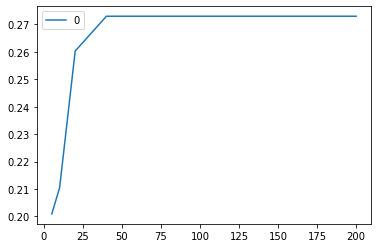

In [77]:
pd.DataFrame(res, [5, 10, 20, 40, 100, 200]).plot()

## Прогноз на тесте

Чтобы сделать прогноз на валидационной выборке, обучим модель на всех данных. Это нужно для того, чтобы модель обучилась на как можно более объёмном наборе различных данных.

In [94]:
df = pd.read_csv('credit_scoring_train.csv')
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(0)
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

In [95]:
trees.fit(df.drop('SeriousDlqin2yrs', 1), df['SeriousDlqin2yrs'])

/var/folders/1d/ns2_mhcx2599g7zqsmbp6x0m0000gn/T/ipykernel_91976/3208191470.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  trees.fit(df.drop('SeriousDlqin2yrs', 1), df['SeriousDlqin2yrs'])


DecisionTreeClassifier(max_depth=14, random_state=42)

Далее загрузим тестовый датасет.

In [96]:
test_set = pd.read_csv('credit_scoring_test.csv')